In [1]:
%matplotlib inline
import numpy as np

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import datasets
import matplotlib.pyplot as plt

from linear_regression import  linear_regression
from nearest_neighbour import nearest_neighbour
from regression_forest import regression_forest
from gaussian_process import gaussian_process
from sarcos_data import data_processor

### Data

In [2]:
dp = data_processor.DataProcessor(0.6)

In [3]:
print(dp.training_features.shape)

(26690, 21)


In [4]:
def normalise_data(x_unnormalised):
    b = np.mean(x_unnormalised, axis=0)
    a = np.std(x_unnormalised, axis=0)
    x_normalised = (x_unnormalised - b)/a
    
    return x_normalised, a, b


In [5]:
def plot_estimated_y_for_input_x(original_x, x, w,):
    y = np.dot(x, w)
    print(y.shape)
    plt.plot(original_x, y , 'r-')

In [6]:
def plot_data(x, y, style='b+'):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, style)
    plt.grid(True)

In [7]:
# # Don't have a toy problem yet so use a place holder
num_features = 1
X, y = datasets.make_regression(n_samples=50, n_features=num_features, noise=0)
number_samples = int(X.shape[0])

train_ratio = 0.6
split = int(number_samples * train_ratio)

X, _, _ = normalise_data(X)
y, _, _ = normalise_data(y)
x_train = X[:split]
# x_train, _, _ = normalise_data(x_train)

y_train = y[:split]
# y_train, _, _ = normalise_data(y_train)

x_test = X[split:]
# x_test, _, _ = normalise_data(x_test)

y_test = y[split:]
# y_test, _, _ = normalise_data(y_test)
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test= np.array(y_test)

x_train.shape

(30, 1)

In [8]:
def rmse(Y, Y_pred):
    rmse = np.sqrt(sum((Y - Y_pred) ** 2) / len(Y))
    return rmse

def r2_score(Y, Y_pred):
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

### Random Forest

In [9]:
RF = regression_forest.RegressionForest(x_train, y_train, 5)
RF.train_forest()

/Users/omarreid/Envs/selerio/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/omarreid/Envs/selerio/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Making Predictions
Loss:
0.010422961517535247


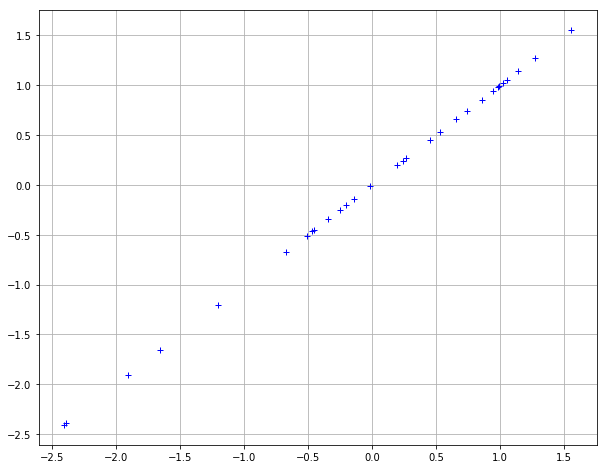

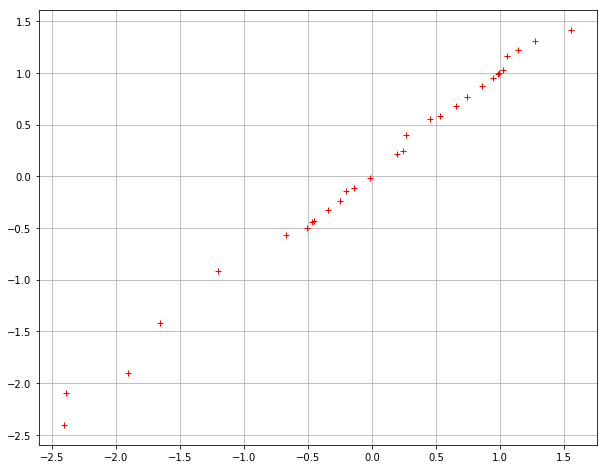

In [10]:
y_predictions = RF.make_prediction(x_train)

# print("All Predictions")
# print(y_predictions)
plot_data(x_train, y_train)
loss = RF.get_loss(y_predictions, y_train)
plot_data(x_train, y_predictions, 'r+')
print("Loss:")
print(loss)




### Nearest Neighbor

In [11]:
k_value = 5
NN = nearest_neighbour.NearestNeighbour(x_train, y_train, k_value)

NN.try_multiple_k_vals(x_test, y_test,  range(1, 2))



K Val: 1
Error: 8.425995840960217


[(1, 8.425995840960217)]

### Gaussian Process 

In [12]:
gp = gaussian_process.GaussianProcess(x_train, y_train)
mean, covariance = gp.train()

num_samples = 1
all_samples = gp.draw_samples(mean, covariance, num_samples)


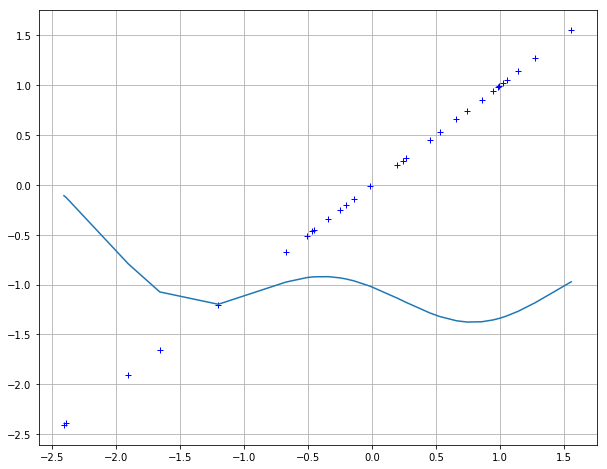

In [13]:
plot_data(x_train, y_train)
x_train_gp = np.squeeze(x_train)
for ys in all_samples: 
    lists = sorted(zip(*[x_train_gp, ys]))
    new_xs,  new_ys = list(zip(*lists))
    plt.plot(new_xs, new_ys)

plt.show()

In [14]:
predictions = gp.predict(x_test, covariance)

(20, 20)
(20,)
1.2481337796315004


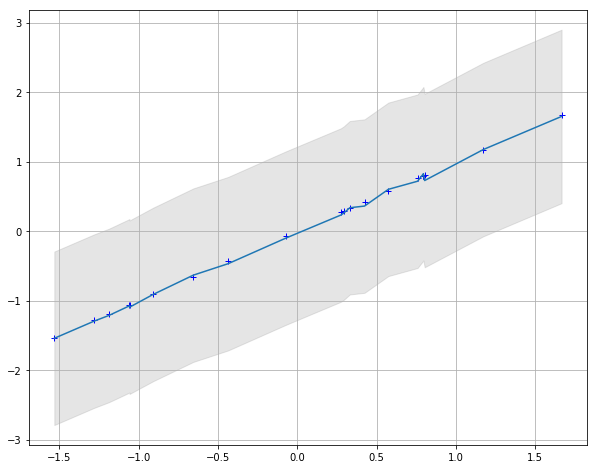

In [21]:
new_mean, new_covariance = predictions
print(new_covariance.shape)
print(new_mean.shape)

plot_data(x_test, y_test)

new_all_samples = gp.draw_samples(new_mean, new_covariance, num_samples)
x_test_gp = np.squeeze(x_test)
for y_s in new_all_samples: 
    lists = sorted(zip(*[x_test_gp, y_s]))
    new_xs,  new_ys = list(zip(*lists))
    error = rmse(y_test, new_ys) 
    print(error)
    plt.plot(new_xs, new_ys)
    plt.fill_between(new_xs,  new_ys - error, new_ys + error, color='gray', alpha=0.2)

plt.show()

#### Linear Regression

In [16]:
def least_squares_error(x, y, w):
    squared_error = np.sum(np.square( x.dot(w) - y ) ** 2)
    return squared_error

In [17]:
LR = linear_regression.LinearRegression()

In [18]:
def process_input(x_values):
    x = x_values[:]
    c = np.ones(x.shape[0])
    add_c = np.vstack((x.T, c))
    new_x = add_c.T
    return new_x

In [19]:
weights = np.ones(x_train.shape[1] + 1)
new_x_train = process_input(x_train)
new_x_test = process_input(x_test)

Optimal W: 
[0.99940367 0.01832506]
Final Loss
0.00016799111170308644
(30,)
Mean least squares error on TRAINING data =  0.00016799111170308644
(20,)
Mean least squares error on TEST data =  2.2716852084392432e-06


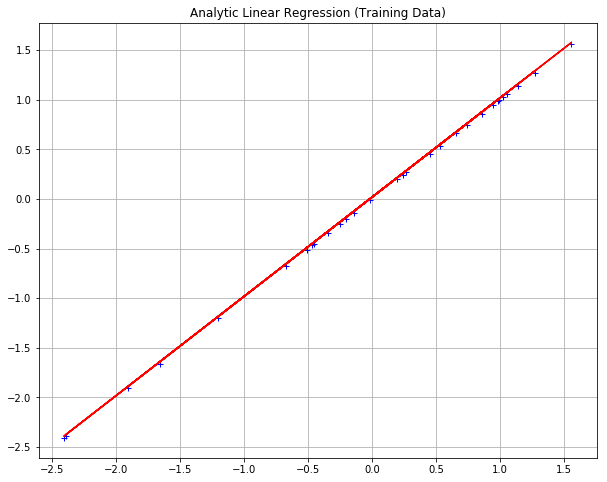

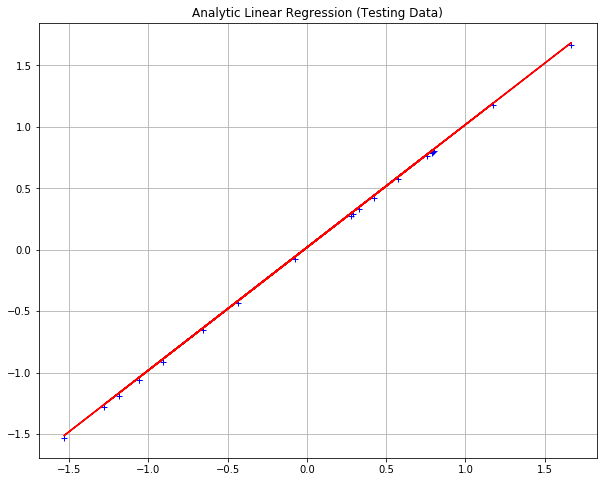

In [20]:
w_opt, loss_history  = LR.get_iterative_solution(new_x_train, y_train,  weights)

print("Optimal W: ")
print(w_opt)
print("Final Loss")
print(loss_history[-1])
plot_data(x_train, y_train)
plt.title('Analytic Linear Regression (Training Data)')
plot_estimated_y_for_input_x(x_train, new_x_train, w_opt)

print('Mean least squares error on TRAINING data = ',
LR._least_squares_loss(new_x_train, y_train, w_opt))

plot_data(x_test, y_test)
plt.title('Analytic Linear Regression (Testing Data)')
plot_estimated_y_for_input_x(x_test, new_x_test, w_opt)
print('Mean least squares error on TEST data = ',
least_squares_error(new_x_test, y_test, w_opt))
    